In [877]:
import geopandas as gpd
import pyogrio as ogr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon, box
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

In [878]:
# bounding box of nyc
bbox = (-74.3, 40.5, -73.7, 40.9)

# real-world example


## get Healthy Stores in NYC


How to request data without downloading the data table:

In [879]:
csvfile_path = 'Recognized_Shop_Healthy_Stores_20240730 .csv'
df = pd.read_csv("Recognized_Shop_Healthy_Stores_20240730 .csv")
df['Longitude'] = df['Longitude'].astype(float)
df['Latitude'] = df['Latitude'].astype(float)
Healthy_Stores = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(
        df['Longitude'],
        df['Latitude']
    )
)

In [880]:
Healthy_Stores.fillna("na", inplace=True)

/var/folders/zg/m42dmv251nj6ml7dyhj2cgdr0000gn/T/ipykernel_57267/1731599337.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Healthy_Stores.fillna("na", inplace=True)


In [881]:
#Data set represents 'Healthy Food' options in NYC
Healthy_Stores.columns

Index(['Store Name', 'Street Address', 'Address', 'Borough', 'Zip \nCode',
       'Year Awarded', 'Program \nWave', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'BIN', 'BBL',
       'Census Tract (2020)', 'Neighborhood Tabulation Area (NTA) (2020)',
       'geometry'],
      dtype='object')

In [882]:
Healthy_Stores.drop_duplicates(subset="Store Name", inplace=True)

In [883]:
#Looking at Years where each stores were awarded
Healthy_Stores['Year Awarded'].value_counts()

Year Awarded
2017    111
2020    106
2023     83
2018     65
2019     57
2015     55
2016     42
2013     36
2022     29
2014     23
Name: count, dtype: int64

In [884]:
#Looking at Stores by Borough
Healthy_Stores.Borough.value_counts()

Borough
Bronx       251
Brooklyn    228
New York    128
Name: count, dtype: int64

In [885]:
#Looking at Stores by Borough
Healthy_Stores['Zip \nCode'].value_counts()

Zip \nCode
10453    56
10029    51
11221    49
10457    48
11212    46
11206    44
10456    40
10452    34
11237    29
10037    25
10035    22
11208    21
11233    20
11207    19
10459    18
10458    18
10460    16
10030    16
10451    14
10027    14
10455     6
10474     1
Name: count, dtype: int64

SUMMARY:
According to the data index search, I was able to find that Culling a list of Manhattan by zip codes with store locations and names will be useful for further data display and mapping.

## build graph to allow us to search


In [886]:
# List of Manhattan zip codes from the provided list
manhattan_zip_codes = ['10029', '10037', '10035', '10030', '10027']

In [887]:
# Filter the GeoDataFrame for Manhattan zip codes
mh_Heathy_Stores = Healthy_Stores[Healthy_Stores['Zip \nCode'].astype(str).isin(manhattan_zip_codes)]

In [888]:
# Check the resulting filtered GeoDataFrame
if not Healthy_Stores_Manhattan.empty:
    print(Healthy_Stores_Manhattan)

                            Store Name               Street Address Address  \
110  Comidas Dominicanas Capellan Deli             1626 Park Avenue      na   
111                     Deli Superette        1858 Lexington Avenue      na   
112                    Puchito Grocery              2122 2nd Avenue      na   
113                     Annabelle Deli              2121 2nd Avenue      na   
114                     Juice Bar Deli        308 East 116th Street      na   
..                                 ...                          ...     ...   
546                     AJ Food Center          1 West 131th Street      na   
547                 FunFair Deli Corp.             537 Lenox Avenue      na   
549                    Domingo Grocery              2591 8th Avenue      na   
550        Farida Halal African Market  2529 Frederick Douglas Blvd      na   
551           135th St. Deli & Grocery        266 West 135th Street      na   

      Borough  Zip \nCode  Year Awarded  Program \n

In [889]:
mh_bbox = Healthy_Stores_Manhattan.total_bounds

In [890]:
mh_bbox

array([-73.959354,  40.786099, -73.932769,  40.821482])

In [891]:
# Create a network for the filtered area using the bounding box
mh_network = ox.graph_from_bbox(
        north=mh_bbox[3], south=mh_bbox[1], east=mh_bbox[2], west=mh_bbox[0], network_type="walk"
    )

/var/folders/zg/m42dmv251nj6ml7dyhj2cgdr0000gn/T/ipykernel_57267/2707225345.py:2: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  mh_network = ox.graph_from_bbox(


In [827]:
mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network)

In [828]:
mh_net_edges

osmid              name      highway  \
u           v           key                                              
42421852    7087041449  0       5668986   La Salle Street  residential   
            6993051360  0     309956784  Amsterdam Avenue    secondary   
            10055027280 0     309956784  Amsterdam Avenue    secondary   
42424235    9557110399  0       5672967        5th Avenue    secondary   
            9557110400  0     226007080        5th Avenue    secondary   
...                                 ...               ...          ...   
12016010893 2091642195  0    1296756216               NaN      footway   
12027161903 7598641859  0     813473911               NaN      footway   
                        1     813473909               NaN      footway   
            7598688548  0     813473911               NaN      footway   
12036804275 1778676696  0    1299393701               NaN      footway   

                             oneway reversed  length lanes maxspeed  \
u           v           key                                           
42421852    7087041449  0     False    False  12.545   NaN      NaN   
            6993051360  0     False    False   8.530   NaN      NaN   
            10055027280 0     False     True   6.902   NaN      NaN   
42424235    9557110399  0     False     True   7.448     1   25 mph   
            9557110400  0     False    False   7.521   NaN      NaN   
...                             ...      ...     ...   ...      ...   
12016010893 2091642195  0     False     True   7.036   NaN      NaN   
12027161903 7598641859  0     False     True  38.704   NaN      NaN   
                        1     False     True  47.245   NaN      NaN   
            7598688548  0     False    False  21.775   NaN      NaN   
12036804275 1778676696  0     False     True   6.268   NaN      NaN   

                                                                      geometry  \
u           v           key                                                      
42421852    7087041449  0    LINESTRING (-73.95682 40.81262, -73.95695 40.8...   
            6993051360  0    LINESTRING (-73.95682 40.81262, -73.95677 40.8...   
            10055027280 0    LINESTRING (-73.95682 40.81262, -73.95686 40.8...   
42424235    9557110399  0    LINESTRING (-73.93447 40.81718, -73.93442 40.8...   
            9557110400  0    LINESTRING (-73.93447 40.81718, -73.93451 40.8...   
...                                                                        ...   
12016010893 2091642195  0    LINESTRING (-73.95798 40.80048, -73.95791 40.8...   
12027161903 7598641859  0    LINESTRING (-73.95851 40.81436, -73.95863 40.8...   
                        1    LINESTRING (-73.95851 40.81436, -73.95848 40.8...   
            7598688548  0    LINESTRING (-73.95851 40.81436, -73.95848 40.8...   
12036804275 1778676696  0    LINESTRING (-73.95802 40.80073, -73.95796 40.8...   

                            service tunnel junction access bridge area  
u           v           key                                             
42421852    7087041449  0       NaN    NaN      NaN    NaN    NaN  NaN  
            6993051360  0       NaN    NaN      NaN    NaN    NaN  NaN  
            10055027280 0       NaN    NaN      NaN    NaN    NaN  NaN  
42424235    9557110399  0       NaN    NaN      NaN    NaN    NaN  NaN  
            9557110400  0       NaN    NaN      NaN    NaN    NaN  NaN  
...                             ...    ...      ...    ...    ...  ...  
12016010893 2091642195  0       NaN    NaN      NaN    NaN    NaN  NaN  
12027161903 7598641859  0       NaN    NaN      NaN    NaN    NaN  NaN  
                        1       NaN    NaN      NaN    NaN    NaN  NaN  
            7598688548  0       NaN    NaN      NaN    NaN    NaN  NaN  
12036804275 1778676696  0       NaN    NaN      NaN    NaN    NaN  NaN  

[23410 rows x 15 columns]

In [829]:
mh_net_nodes

,y,x,highway,street_count,geometry
osmid,,,,,
42421852,40.812622,-73.956823,traffic_signals,3,POINT (-73.95682 40.81262)
42424235,40.817178,-73.934466,stop,4,POINT (-73.93447 40.81718)
42424757,40.806924,-73.935567,traffic_signals,4,POINT (-73.93557 40.80692)
42425127,40.791720,-73.952979,traffic_signals,4,POINT (-73.95298 40.79172)
42425423,40.814743,-73.934554,NaN,3,POINT (-73.93455 40.81474)
...,...,...,...,...,...
12015891760,40.800725,-73.958353,NaN,1,POINT (-73.95835 40.80072)
12016010886,40.800772,-73.958421,crossing,4,POINT (-73.95842 40.80077)
12016010893,40.800485,-73.957977,NaN,1,POINT (-73.95798 40.80048)


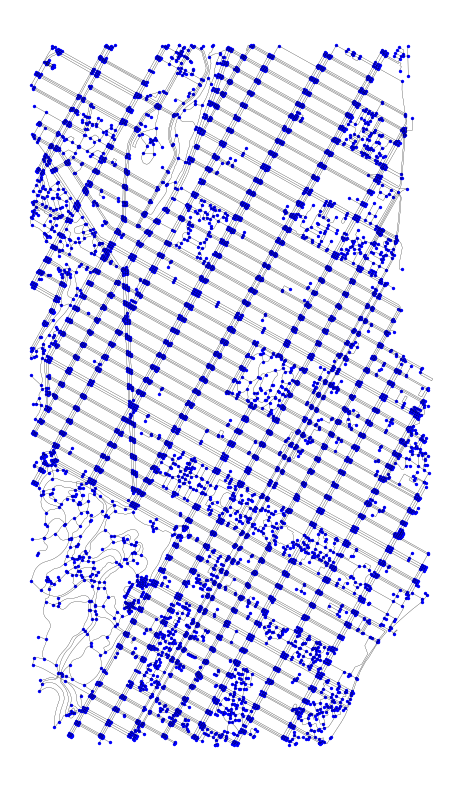

In [830]:
#using nodes and edges, create a map of all the stores within the set bounds of zip codes.  
# Manhattan zip codes: ['10029', '10037', '10035', '10030', '10027']
#Below map displays all the locations of health food options within the bounds.
ax = mh_net_edges.plot(color="black", linewidth=0.1, figsize=(10, 10))
mh_net_nodes.plot(ax=ax, color="blue", markersize=2).set_axis_off()

### get directions between buell hall and a random store using osmnx


In [831]:
#Establish point A 
buell_hall = Point(-73.9614755, 40.8077424)

In [832]:
# get the nearest node to buell hall
orig = ox.distance.nearest_nodes(mh_network, buell_hall.x, buell_hall.y)
sample = Healthy_Stores.sample(1)
dest = ox.distance.nearest_nodes(mh_network, sample.geometry.x, sample.geometry.y)[0]

In [833]:
orig

7004347451

In [834]:
dest

5478861092

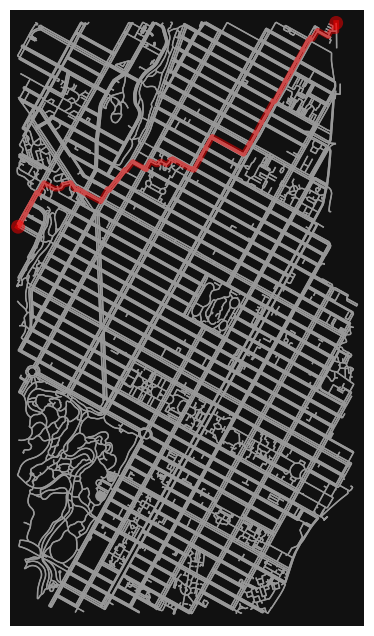

In [835]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(mh_network, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(mh_network, route, node_size=0)

In [836]:
edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

# convert meters to miles
sum(edge_lengths) / 1609.34

2.077620018144084

In [837]:
# Display the first few rows of the dataframe
healthy_stores_df.head()

,Store Name,Street Address,Address,Borough,Zip \nCode,Year Awarded,Program \nWave,Latitude,Longitude,Community Board,Council District,BIN,BBL,Census Tract (2020),Neighborhood Tabulation Area (NTA) (2020)
0,Rivas Deli Grocery,651 East 183rd Street,NaN,Bronx,10458,2013,1,40.852568,-73.887484,206,15,2012464.0,2.030870e+09,391,BX0603
1,C-Town,1761 Southern Boulevard,NaN,Bronx,10460,2013,1,40.837267,-73.888016,203,15,2009878.0,2.029400e+09,155,BX0303
2,La India Mini Market,1942 Marmion Avenue,NaN,Bronx,10460,2013,1,40.842942,-73.887136,206,15,2010156.0,2.029600e+09,36502,BX0602
3,Los Hermanos,2019 Vyse Avenue,NaN,Bronx,10460,2013,1,40.842391,-73.881835,206,15,2013203.0,2.031270e+09,363,BX0601
4,Price Choice Food Market,820 East 180th Street,NaN,Bronx,10460,2013,1,40.846173,-73.884871,206,15,2012955.0,2.031080e+09,36501,BX0602


In [838]:
# Filter the dataframe to check the entries for the year 2020 and specific zip codes

# List of Manhattan zip codes from the provided list
manhattan_zip_codes = ['10029', '10037', '10035', '10030', '10027']

# Filter the dataframe for entries awarded in 2020
mh_2020 = healthy_stores_df[healthy_stores_df['Year Awarded'] == 2020]

# Further filter the dataframe for the specified Manhattan zip codes
mh_2020_manhattan = mh_2020[mh_2020['Zip \nCode'].astype(str).isin(manhattan_zip_codes)]

# Check the resulting filtered dataframe
mh_2020_manhattan.head()


,Store Name,Street Address,Address,Borough,Zip \nCode,Year Awarded,Program \nWave,Latitude,Longitude,Community Board,Council District,BIN,BBL,Census Tract (2020),Neighborhood Tabulation Area (NTA) (2020)
459,128 T EDGECOMBE DELI CORP,128 EDGECOMBE AVE,NaN,New York,10030,2020,8,40.820961,-73.945071,110,9,1060736.0,1.020430e+09,259,MN1002
460,135 FUTURE LANDM CORP,24 WEST 135TH ST,NaN,New York,10037,2020,8,40.813209,-73.938756,110,9,1053894.0,1.017300e+09,212,MN1002
461,135TH STREET DELI AND GROCERY CORP,266 WEST 135TH ST,NaN,New York,10030,2020,8,40.816213,-73.945877,110,9,1058855.0,1.019400e+09,228,MN1002
462,141 FINEST DELI CORP,332 WEST 141ST ST,NaN,New York,10030,2020,8,40.820958,-73.945375,110,9,1060914.0,1.020480e+09,22102,MN1002
463,2278 DELI AND GROCERY INC,2278 7TH AVE,NaN,New York,10030,2020,8,40.814546,-73.944268,110,9,1058817.0,1.019390e+09,226,MN1002


In [839]:
# Convert the filtered dataframe to a GeoDataFrame
mh_2020_manhattan_gdf = gpd.GeoDataFrame(
    mh_2020_manhattan,
    geometry=gpd.points_from_xy(mh_2020_manhattan['Longitude'], mh_2020_manhattan['Latitude']),
    crs="EPSG:4326"
)

In [840]:
# Calculate the bounding box for the filtered GeoDataFrame
mh_bbox = mh_2020_manhattan_gdf.total_bounds
print("Bounding box for Manhattan stores awarded in 2020:", mh_bbox)

Bounding box for Manhattan stores awarded in 2020: [-73.945895  40.809627 -73.937114  40.821482]


In [841]:
# Create a shapely box object from the bounding box coordinates
bbox_geom = box(mh_bbox[0], mh_bbox[1], mh_bbox[2], mh_bbox[3])

In [842]:
# Create a GeoDataFrame from the box object
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs="EPSG:4326")

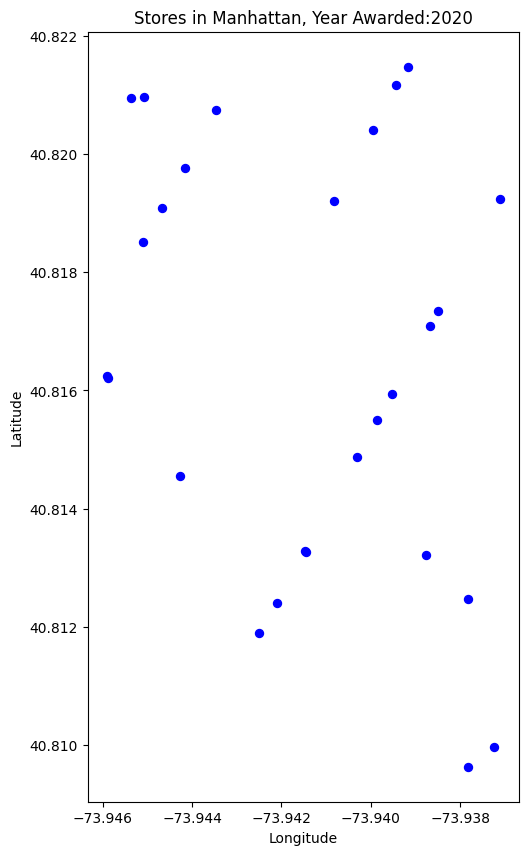

In [843]:
# Plot the GeoDataFrame
ax = mh_2020_manhattan_gdf.plot(color='blue', markersize=33, figsize=(10, 10))

plt.title("Stores in Manhattan, Year Awarded:2020")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [844]:
def distance_from_point(row, origin):
    """
    Returns the distance in miles and the geometry of the shortest path between a point and a destination.

    Parameters:
    row (pd.Series): A row from a pandas DataFrame.
    origin (int): The origin node in the network.
    """

    dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)  # [0]
    route = ox.shortest_path(mh_network, origin, dest, weight="length")
    edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

    route_geom = ox.routing.route_to_gdf(mh_network, route)
    route_geom = route_geom.geometry.unary_union

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [845]:
mh_2020_manhattan_gdf["distance_from_buell_hall"] = mh_2020_manhattan_gdf.apply(
    distance_from_point, origin=orig, axis=1
)

In [846]:
mh_2020_manhattan_gdf["distance_from_buell_hall"]

459    {'distance': 1.3171411883132216, 'route_geom':...
460    {'distance': 1.4859986081250698, 'route_geom':...
461    {'distance': 1.081590589931276, 'route_geom': ...
462    {'distance': 1.317624616302335, 'route_geom': ...
463    {'distance': 1.1696770104514895, 'route_geom':...
464    {'distance': 1.343883828153156, 'route_geom': ...
465    {'distance': 1.5385884896914264, 'route_geom':...
466    {'distance': 1.411966396162402, 'route_geom': ...
467    {'distance': 1.6450141051611222, 'route_geom':...
468    {'distance': 1.449091553059018, 'route_geom': ...
469    {'distance': 1.492061341916562, 'route_geom': ...
470    {'distance': 1.6373289671542373, 'route_geom':...
471    {'distance': 1.4983775957846073, 'route_geom':...
472    {'distance': 1.5722209104353337, 'route_geom':...
473    {'distance': 1.0740172990169885, 'route_geom':...
474    {'distance': 1.3224129146109587, 'route_geom':...
475    {'distance': 1.2378447065256566, 'route_geom':...
476    {'distance': 1.538753153

In [847]:
# explode the dictionary into separate columns
mh_2020_manhattan_gdf = pd.concat(
    [
        mh_2020_manhattan_gdf.drop(["distance_from_buell_hall"], axis=1),
        mh_2020_manhattan_gdf["distance_from_buell_hall"].apply(pd.Series),
    ],
    axis=1,
)

In [848]:
mh_2020_manhattan_gdf_routes = gpd.GeoDataFrame(mh_2020_manhattan_gdf, geometry="route_geom", crs="EPSG:4326")

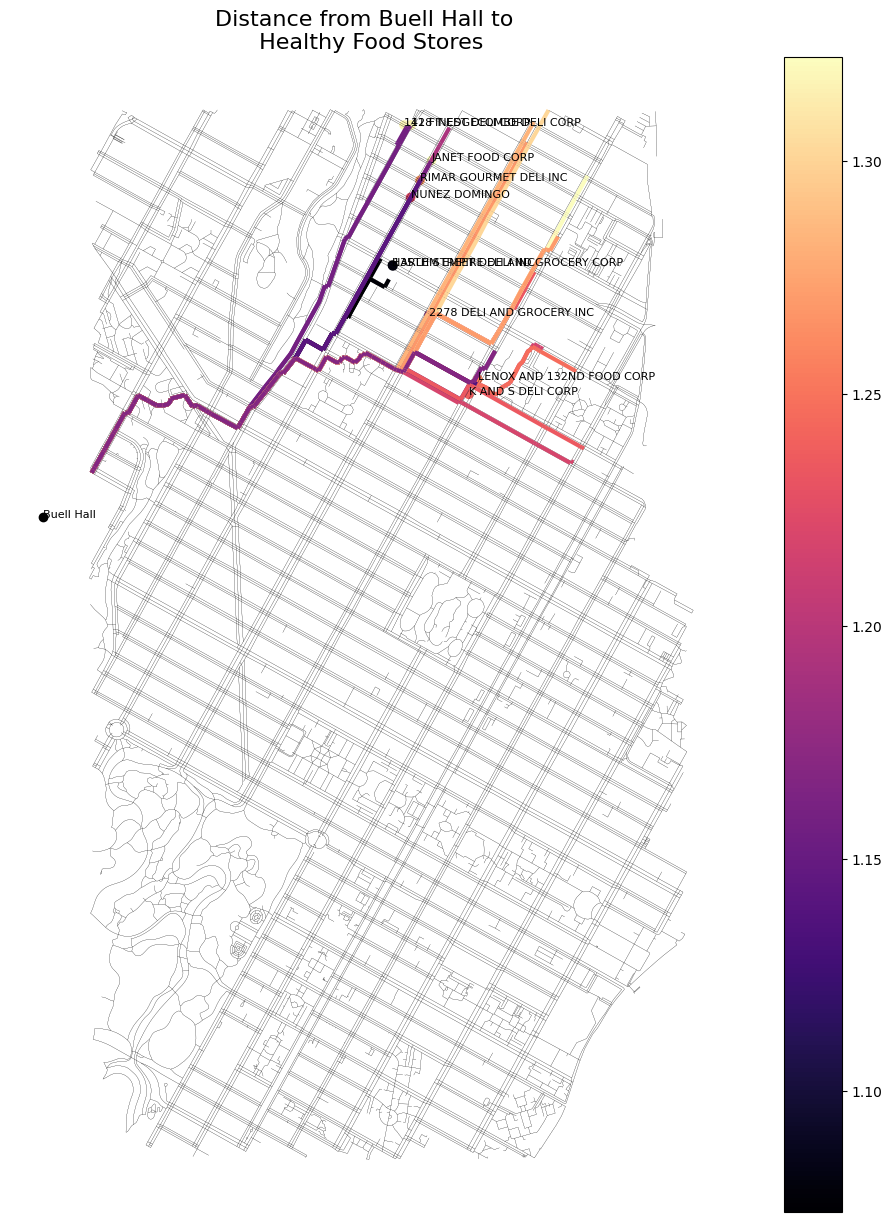

In [849]:
# Select the top 10 stores based on the 'distance' column
top_10_stores = mh_2020_manhattan_gdf.nsmallest(10, 'distance')

# Plot the buell_hall location
fig, ax = plt.subplots(figsize=(15, 15))  # Increase the figure size

gpd.GeoSeries(buell_hall).plot(color="black", ax=ax)

# Plot the network edges (assuming mh_net_edges is defined)
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)

# Plot the routes (assuming mh_2020_manhattan_gdf_routes is defined)
mh_2020_manhattan_gdf_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=3)

# Plot the filtered GeoDataFrame
top_10_stores.plot(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()

# Prepare the labels to be adjusted
texts = []
for x, y, label in zip(top_10_stores.geometry.x, top_10_stores.geometry.y, top_10_stores['Store Name']):
    texts.append(ax.text(x, y, label, fontsize=8))  # Adjust font size if needed

# Label the Buell Hall location
ax.text(buell_hall.x, buell_hall.y, "Buell Hall", fontsize=8)

# Add a title
plt.title("Distance from Buell Hall to \n Healthy Food Stores", fontsize=16)

# Show the plot
plt.show()


In [850]:
mh_2020_manhattan_gdf_routes[["Store Name", "distance"]].sort_values("distance")

,Store Name,distance
473,HARLEM EMPIRE DELI INC,1.074017
461,135TH STREET DELI AND GROCERY CORP,1.081591
463,2278 DELI AND GROCERY INC,1.169677
482,NUNEZ DOMINGO,1.224007
475,K AND S DELI CORP,1.237845
477,LENOX AND 132ND FOOD CORP,1.256071
483,RIMAR GOURMET DELI INC,1.273302
459,128 T EDGECOMBE DELI CORP,1.317141
462,141 FINEST DELI CORP,1.317625
474,JANET FOOD CORP,1.322413


Bounding box for Manhattan stores: [-73.959354  40.786099 -73.932769  40.821482]


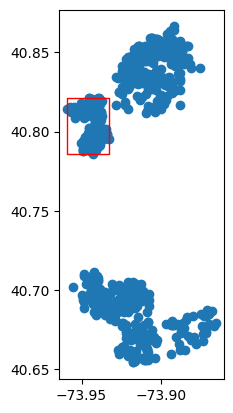

In [851]:
# List of Manhattan zip codes from the provided list
manhattan_zip_codes = ['10029', '10037', '10035', '10030', '10027']

# Filter the GeoDataFrame for Manhattan zip codes
Healthy_Stores_Manhattan = Healthy_Stores[Healthy_Stores['Zip \nCode'].astype(str).isin(manhattan_zip_codes)]

# Check the resulting filtered GeoDataFrame
if not Healthy_Stores_Manhattan.empty:

    # Calculate the bounding box for the filtered GeoDataFrame
    mh_bbox = Healthy_Stores_Manhattan.total_bounds
    print("Bounding box for Manhattan stores:", mh_bbox)

    # Create a shapely box object from the bounding box coordinates
    bbox_geom = box(mh_bbox[0], mh_bbox[1], mh_bbox[2], mh_bbox[3])

    # Create a GeoDataFrame from the box object
    bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs=Healthy_Stores.crs)

    # Plot the Healthy_Stores GeoDataFrame
    ax = Healthy_Stores.plot()

    # Plot the bounding box on the same axes
    bbox_gdf.boundary.plot(ax=ax, color="red", linewidth=1)


In [852]:
# use H3 grid to create a hexagon around the restaurants
# count the number of restaurants in each hexagon
# use pysal to get adjacency between hexagons
# build new network with hexagons as nodes and their adjacency as edges
# use networkx to find the shortest path between hexagons

# get the H3 hexagons

In [853]:
mh_net_nodes

,y,x,highway,street_count,geometry
osmid,,,,,
42421852,40.812622,-73.956823,traffic_signals,3,POINT (-73.95682 40.81262)
42424235,40.817178,-73.934466,stop,4,POINT (-73.93447 40.81718)
42424757,40.806924,-73.935567,traffic_signals,4,POINT (-73.93557 40.80692)
42425127,40.791720,-73.952979,traffic_signals,4,POINT (-73.95298 40.79172)
42425423,40.814743,-73.934554,NaN,3,POINT (-73.93455 40.81474)
...,...,...,...,...,...
12015891760,40.800725,-73.958353,NaN,1,POINT (-73.95835 40.80072)
12016010886,40.800772,-73.958421,crossing,4,POINT (-73.95842 40.80077)
12016010893,40.800485,-73.957977,NaN,1,POINT (-73.95798 40.80048)


In [854]:
mh_net_nodes["h3"] = mh_net_nodes.apply(
    lambda x: h3.geo_to_h3(x.geometry.centroid.y, x.geometry.centroid.x, 9), axis=1
)

In [855]:
mh_net_nodes["h3"]

osmid
42421852       892a1008c33ffff
42424235       892a100ab0bffff
42424757       892a1008d93ffff
42425127       892a1008d63ffff
42425423       892a100ab0fffff
                    ...       
12015891760    892a1008d4bffff
12016010886    892a1008d4bffff
12016010893    892a1008d4bffff
12027161903    892a1008c07ffff
12036804275    892a1008d4bffff
Name: h3, Length: 6820, dtype: object

In [856]:
# create hexagons for AOI
mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(
    lambda x: (h3.h3_to_geo_boundary(x))
)

/var/folders/zg/m42dmv251nj6ml7dyhj2cgdr0000gn/T/ipykernel_57267/2385662124.py:2: UserWarning: Geometry column does not contain geometry.
  mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(


In [857]:
# flip order of coordinates for each tuple
mh_net_nodes["geometry"] = mh_net_nodes["geometry"].apply(
    lambda x: Polygon([(y, x) for x, y in x])
)

In [858]:
mh_net_nodes.crs = "EPSG:4326"

In [859]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [860]:
# mh_net_edges.to_crs("EPSG:2263", inplace=True)
# mh_net_nodes.to_crs("EPSG:2263", inplace=True)

In [861]:
mh_net_nodes

,y,x,highway,street_count,geometry,h3
osmid,,,,,,
42421852,40.812622,-73.956823,traffic_signals,3,"POLYGON ((-73.95607 40.81332, -73.95818 40.812...",892a1008c33ffff
42424235,40.817178,-73.934466,stop,4,"POLYGON ((-73.93486 40.81917, -73.93697 40.818...",892a100ab0bffff
42424757,40.806924,-73.935567,traffic_signals,4,"POLYGON ((-73.93446 40.80860, -73.93657 40.807...",892a1008d93ffff
42425127,40.791720,-73.952979,traffic_signals,4,"POLYGON ((-73.95321 40.79487, -73.95532 40.793...",892a1008d63ffff
42425423,40.814743,-73.934554,NaN,3,"POLYGON ((-73.93262 40.81659, -73.93473 40.815...",892a100ab0fffff
...,...,...,...,...,...,...
12015891760,40.800725,-73.958353,NaN,1,"POLYGON ((-73.95994 40.80263, -73.96205 40.801...",892a1008d4bffff
12016010886,40.800772,-73.958421,crossing,4,"POLYGON ((-73.95994 40.80263, -73.96205 40.801...",892a1008d4bffff
12016010893,40.800485,-73.957977,NaN,1,"POLYGON ((-73.95994 40.80263, -73.96205 40.801...",892a1008d4bffff


In [862]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [863]:
mh_net_nodes_copy = mh_net_nodes.copy() 

In [864]:
mh_net_nodes_copy.drop_duplicates(subset=["h3"], inplace=True)

<Axes: >

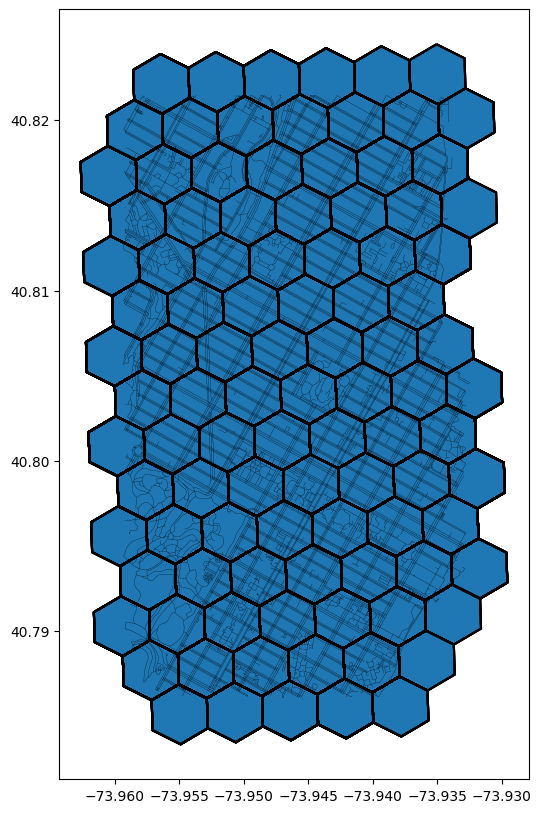

In [865]:
ax = mh_net_nodes.plot(figsize=(10, 10))
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_edges.plot(
    ax=ax,
    color="black",
    linewidth=0.1,
)  # .set_axis_off()

In [866]:
from lonboard import Map, PolygonLayer

In [867]:
layer = PolygonLayer.from_geopandas(
    mh_net_nodes[["geometry"]],
    get_line_color="black",
    get_fill_color="none",
    get_line_width=3,
)
# edges_layer = LineLayer.from_geopandas(
#     mh_net_edges[["geometry"]],
#     get_line_color="black",
#     get_fill_color="none",
#     get_line_width=1,
# )
m = Map(
    [
        layer,
    ]
)
m

Map(layers=[PolygonLayer(get_fill_color=(0, 0, 0, 0), get_line_color=(0, 0, 0, 255), get_line_width=3.0, table…

In [868]:
mh_net_nodes.drop_duplicates(subset="h3", inplace=True)

In [869]:
# create an adjacency matrix for the hexagons
w = lps.weights.Queen.from_dataframe(mh_net_nodes)

/var/folders/zg/m42dmv251nj6ml7dyhj2cgdr0000gn/T/ipykernel_57267/2435529990.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(mh_net_nodes)


In [870]:
w

In [871]:
# get neighbors for each hexagon
neighbors = {k: v for k, v in w.neighbors.items()}

In [872]:
neighbors

{0: [96, 35, 70, 22, 8, 11],
 1: [97, 33, 4, 86, 38],
 2: [44, 45, 46, 87],
 3: [32, 66, 23, 40, 91, 78],
 4: [72, 1, 86],
 5: [32, 40, 57, 27, 28, 30],
 6: [67, 51, 37, 52, 7, 94],
 7: [82, 51, 6, 56, 94, 62],
 8: [0, 35, 69, 70, 9, 76],
 9: [17, 69, 70, 8, 41, 10],
 10: [64, 65, 17, 36, 9, 41],
 11: [0, 96, 99, 70, 12],
 12: [99, 70, 41, 42, 11, 13],
 13: [64, 80, 41, 42, 12, 14],
 14: [80, 42, 13],
 15: [16, 49, 86, 87, 72, 73],
 16: [49, 17, 68, 69, 73, 15],
 17: [16, 65, 49, 69, 9, 10],
 18: [19, 53, 43, 74, 75, 59],
 19: [34, 18, 20, 59, 75, 27],
 20: [34, 35, 19, 21, 75, 76],
 21: [34, 35, 20, 22, 71, 29],
 22: [0, 96, 35, 21, 71],
 23: [66, 3, 85, 24, 77, 78],
 24: [66, 67, 50, 23, 25, 77],
 25: [81, 67, 52, 24, 26, 77],
 26: [81, 52, 25, 92],
 27: [34, 19, 5, 59, 28, 30],
 28: [34, 5, 57, 58, 27, 29],
 29: [34, 21, 71, 58, 28],
 30: [32, 5, 59, 27, 60, 31],
 31: [32, 66, 50, 89, 60, 30],
 32: [66, 3, 5, 40, 30, 31],
 33: [1, 97, 98, 38, 39, 79],
 34: [19, 20, 21, 27, 28, 29],


In [873]:
# create networkx graph from adjacency matrix
G = nx.Graph(neighbors)

In [874]:
# get the path between two nodes
path = nx.shortest_path(G, 22, 23)

In [875]:
path

[22, 21, 34, 27, 5, 32, 3, 23]

/var/folders/zg/m42dmv251nj6ml7dyhj2cgdr0000gn/T/ipykernel_57267/1576104426.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.x,
/var/folders/zg/m42dmv251nj6ml7dyhj2cgdr0000gn/T/ipykernel_57267/1576104426.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.y,


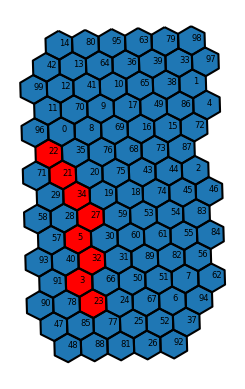

In [876]:
# plot the path
ax = mh_net_nodes.plot()
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_nodes.iloc[path].plot(ax=ax, color="red").set_axis_off()

# label cells with their index
for x, y, label in zip(
    mh_net_nodes.geometry.centroid.x,
    mh_net_nodes.geometry.centroid.y,
    neighbors.keys(),
):
    ax.text(x, y, label, fontsize=6)

Conclusion:
Maps and graphs display shortest distance from Buell Hall to near by Healthy Food stores.  The only downfall from using this data set is that it does not display all of Manhattan zipcodes.  So these maps are not displaying the most accurate data but only accurate within the information it is pulling from.  